This program parses data saved by new Rigol DS Oscilloscope.

It contains raw Voltage(Time) dependences from two channels of the oscilloscope.

### Used Modules

In [128]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

### Full path of .csv files

In [129]:
filename = 'Mg_14.03/Mg4.csv'

### V(t) for CH1 & CH2 in df

In [130]:
df = pd.read_csv(filename,
                header=0,
                names = ['Time/s', 'CH1/V', 'CH2/V']
)

df['Time/s'] -= df['Time/s'].iloc[0]
df['Time/mus'] = df['Time/s']*1e+6

df['CH1/V'] = -df['CH1/V']
df['CH2/V'] = -df['CH2/V']

df.tail()

,Time/s,CH1/V,CH2/V,Time/mus
9995,0.001999,0.001229,-0.014266,1999.0
9996,0.001999,0.000819,-0.014674,1999.2
9997,0.001999,0.000819,-0.014674,1999.4
9998,0.002000,0.000819,-0.014266,1999.6
9999,0.002000,0.000410,-0.013858,1999.8


<AxesSubplot: xlabel='Time/mus', ylabel='CH1/V'>

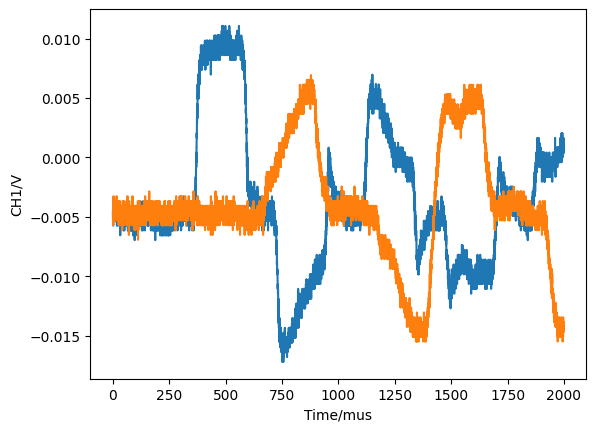

In [131]:
sns.lineplot(data=df,
                x = 'Time/mus',
                y = 'CH1/V',)

sns.lineplot(data=df,
                x = 'Time/mus',
                y = 'CH2/V',)

### CH1/V/rm/50 & CH2/V/rm/50

<AxesSubplot: xlabel='Time/mus', ylabel='CH1/V/rm/50'>

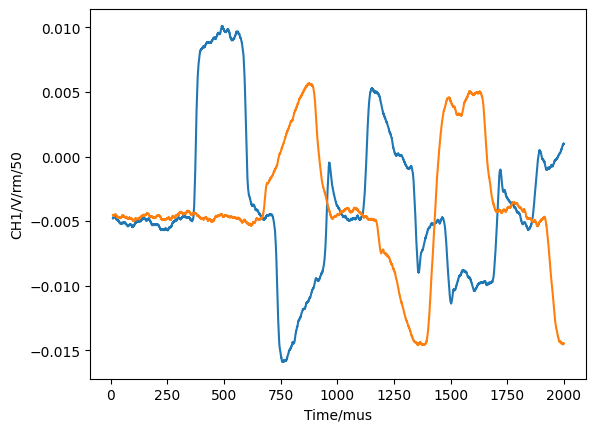

In [132]:
df['CH1/V/rm/50'] = df['CH1/V'].rolling(50).mean()
df['CH2/V/rm/50'] = df['CH2/V'].rolling(50).mean()

sns.lineplot(data=df,
                x = 'Time/mus',
                y = 'CH1/V/rm/50',)

sns.lineplot(data=df,
                x = 'Time/mus',
                y = 'CH2/V/rm/50',)

### CH1/V/zero & CH2V/zero

<AxesSubplot: xlabel='Time/mus', ylabel='CH1/V/zero'>

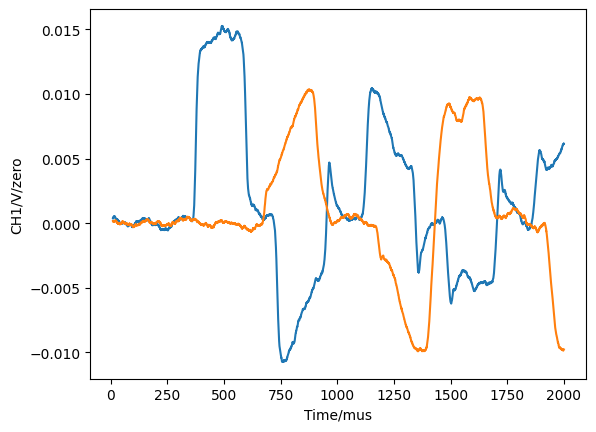

In [133]:
trig_start = 250 # mu s

CH1_zero = df[df['Time/mus'].between(left=0, right=trig_start)]['CH1/V/rm/50'].mean()
df['CH1/V/zero'] = df['CH1/V/rm/50'] - CH1_zero

CH2_zero = df[df['Time/mus'].between(left=0, right=trig_start)]['CH2/V/rm/50'].mean()
df['CH2/V/zero'] = df['CH2/V/rm/50'] - CH2_zero

sns.lineplot(data=df,
                x = 'Time/mus',
                y = 'CH1/V/zero',)

sns.lineplot(data=df,
                x = 'Time/mus',
                y = 'CH2/V/zero',)

### Voltage to stress

Let $\sigma = K \cdot V$, $K_{exp}$ - experimental coefficient and $K_{th}$ - theoretical coefficient.

In [134]:
alpha = 0.004 # mV/kg
g = 9.81 # N/kg

d = 20 # mm
S = np.pi*d*d/4 # mm2

rho = 8300 # kg/m3
E = 220 # GPa
nu = 0.3

Gf = 2.1
Kwb = 2*(1+nu)
Vin = 12 # V

Kexp = g/S/alpha # MPa/mV
Kth = E/Vin/Kwb/Gf # MPa/mV
Kexp_new = 6.75 # MPa/mV
print('Kexp = %.2f MPa/mV, Kth = %.2f MPa/mV' % (Kexp, Kth))

Kexp = 7.81 MPa/mV, Kth = 3.36 MPa/mV


### The stress and strain pulses

<AxesSubplot: xlabel='Time/mus', ylabel='CH1/MPa'>

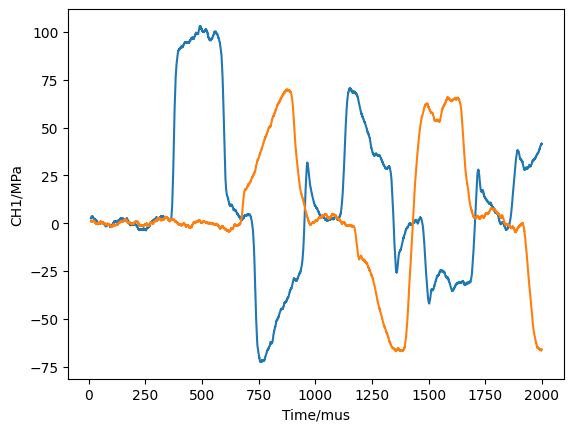

In [135]:
df['CH1/MPa'] = df['CH1/V/zero'] * Kexp_new*1e+3
df['CH2/MPa'] = df['CH2/V/zero'] * Kexp_new*1e+3

df['CH1/strain'] = df['CH1/MPa'] / E *1e-3
df['CH2/strain'] = df['CH2/MPa'] / E * 1e-3


sns.lineplot(data=df,
                x = 'Time/mus',
                y = 'CH1/MPa',)

sns.lineplot(data=df,
                x = 'Time/mus',
                y = 'CH2/MPa',)

# we can clear the database with data that is not needed anymore
# df.drop(columns=['Time/s', 'CH1/V/rm/50', 'CH1/V/zero'], inplace=True)

### start of i, t, r pulses

We find the beginning of the incident pulse by the prevailing of "zero" level (10 MPa).

In [136]:
noiseZero = 0.6*Kexp_new # MPa

i_start = df[df['CH1/MPa'] > noiseZero].index[0]

The shift to syncronise gauges is evaluated by their position on bars.

<AxesSubplot: xlabel='Time/mus', ylabel='CH1/MPa'>

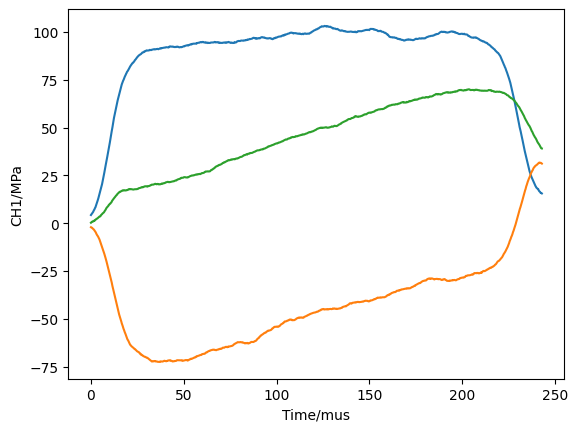

In [137]:
c = np.sqrt(E/rho*1e+9) # m/s
L1 = 0.92 # m
L2 = 0.65 # m

dtR = 2*L1/c*1e+6 # mus
dtT = (L1+L2)/c*1e+6 # mus
dtI = df.loc[i_start]['Time/mus'] # mus

r_start = df[df['Time/mus'] > dtI+dtR].index[0]
t_start = df[df['Time/mus'] > dtI+dtT].index[0]

dfI = df[['Time/mus', 'CH1/MPa']].copy()
dfR = df[['Time/mus', 'CH1/MPa']].copy()
dfT = df[['Time/mus', 'CH2/MPa']].copy()

dfI['Time/mus'] = dfI['Time/mus'].shift(i_start)
dfR['Time/mus'] = dfR['Time/mus'].shift(r_start)
dfT['Time/mus'] = dfT['Time/mus'].shift(t_start)

striker = 60 # cm
T = 2*striker*1e-2 / c * 1e+6 + 10 # mus

dfI = dfI[dfI['Time/mus']<T].dropna()
dfT = dfT[dfT['Time/mus']<T].dropna()
dfR = dfR[dfR['Time/mus']<T].dropna()

sns.lineplot(data=dfI,
                x = 'Time/mus',
                y = 'CH1/MPa',)

sns.lineplot(data=dfR,
                x = 'Time/mus',
                y = 'CH1/MPa',)

sns.lineplot(data=dfT,
                x = 'Time/mus',
                y = 'CH2/MPa',)


### dfP synchronised pulses

We merge them by their "times".

In [138]:
dfP = pd.merge(left=dfI, right=dfR, how='inner',
                left_on='Time/mus', right_on='Time/mus', suffixes=('_I','_R'))

dfP.head()


,Time/mus,CH1/MPa_I,CH1/MPa_R
0,0.0,4.304301,-2.054739
1,0.2,4.636077,-2.220627
2,0.4,4.857261,-2.275923
3,0.6,5.133741,-2.331219
4,0.8,5.465517,-2.607699


In [139]:
dfP = pd.merge(left=dfP, right=dfT, how='inner',
                left_on='Time/mus', right_on='Time/mus', suffixes=('_P','_T'))

new_names = {
    'CH1/MPa_I':'I/MPa',
    'CH1/MPa_R':'R/MPa',
    'CH2/MPa':'T/MPa',
}

dfP.rename(columns=new_names, inplace=True)

dfP.head()

,Time/mus,I/MPa,R/MPa,T/MPa
0,0.0,4.304301,-2.054739,0.275862
1,0.2,4.636077,-2.220627,0.440940
2,0.4,4.857261,-2.275923,0.716070
3,0.6,5.133741,-2.331219,0.771096
4,0.8,5.465517,-2.607699,0.826122


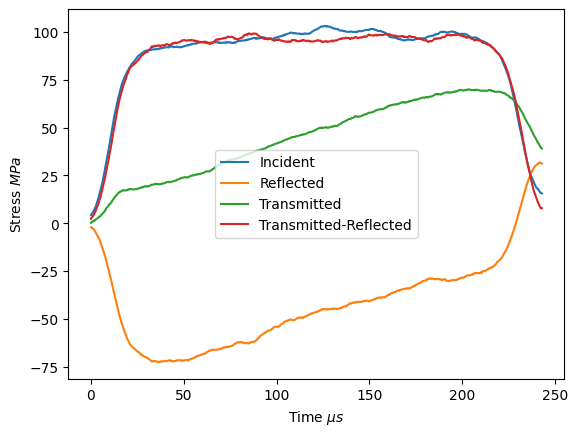

In [140]:

dfP['T-R/MPa'] = dfP['T/MPa'] - dfP['R/MPa']

sns.lineplot(data=dfP,
                    x = 'Time/mus',
                    y = 'I/MPa',
                    label = 'Incident',)

sns.lineplot(data=dfP,
                x = 'Time/mus',
                y = 'R/MPa',
                label = 'Reflected',)

sns.lineplot(data=dfP,
                x = 'Time/mus',
                y = 'T/MPa',
                label = 'Transmitted',)

sns.lineplot(data=dfP,
                x = 'Time/mus',
                y = 'T-R/MPa',
                label = 'Transmitted-Reflected',)

plt.xlabel(r'Time $\mu s$')
plt.ylabel(r'Stress $MPa$')

plt.legend(loc='best')

### Stress(t) and Strain(t)

In [141]:
Ls = 4e-3 # m
Ds = 8 # mm

As = np.pi*Ds*Ds/4 # mm2

# average stress in the specimen
# dfP['Stress/MPa'] = 1/2*S/As*(dfP['I/MPa']+dfP['R/MPa']+dfP['T/MPa'])
# stress going through the specimen
dfP['Stress/MPa'] = S/As*(dfP['T/MPa'])
dfP['I-R-T/MPa'] = dfP['I/MPa']-dfP['R/MPa']-dfP['T/MPa']
dfP['dotStrain'] = c/Ls * 1e-9/E * (dfP['I/MPa']-dfP['R/MPa']-dfP['T/MPa'])*1e+6
dfP['dStrain'] = (dfP['dotStrain'].shift(-1)+dfP['dotStrain'])/2*(dfP['Time/mus'].shift(-1)-dfP['Time/mus'])*1e-6
dfP['Strain'] = dfP['dStrain'].cumsum()

dfP[['Time/mus', 'dotStrain', 'dStrain', 'Strain']].head()

,Time/mus,dotStrain,dStrain,Strain
0,0.0,35.589355,0.000007,0.000007
1,0.2,37.535134,0.000008,0.000015
2,0.4,37.543032,0.000008,0.000022
3,0.6,39.162146,0.000008,0.000031
4,0.8,42.398793,0.000009,0.000039


Text(0, 0.5, 'Stress $MPa$')

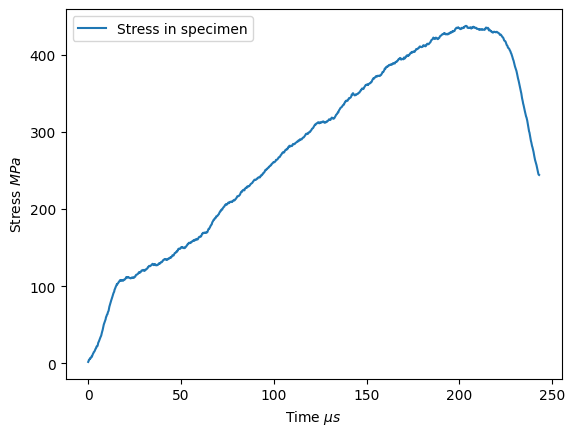

In [142]:
sns.lineplot(data=dfP,
                x = 'Time/mus',
                y = 'Stress/MPa',
                label = 'Stress in specimen',)

plt.xlabel(r'Time $\mu s$')
plt.ylabel(r'Stress $MPa$')

495


<AxesSubplot: xlabel='Time/mus', ylabel='Strain'>

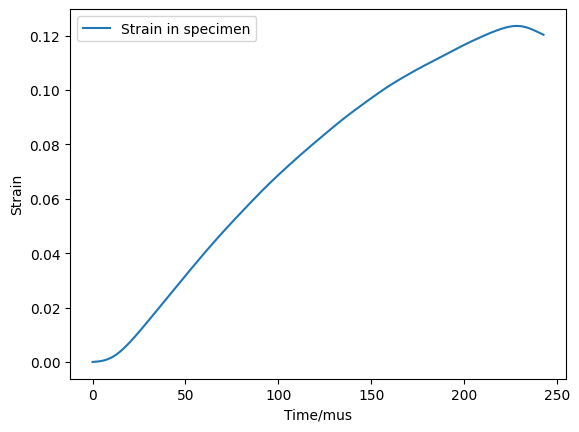

In [143]:
strainRate = dfP['dotStrain'].mean()

print('%.f' % strainRate)

sns.lineplot(data=dfP,
                x = 'Time/mus',
                y = 'Strain',
                label = 'Strain in specimen',)

<AxesSubplot: xlabel='Strain', ylabel='Stress/MPa'>

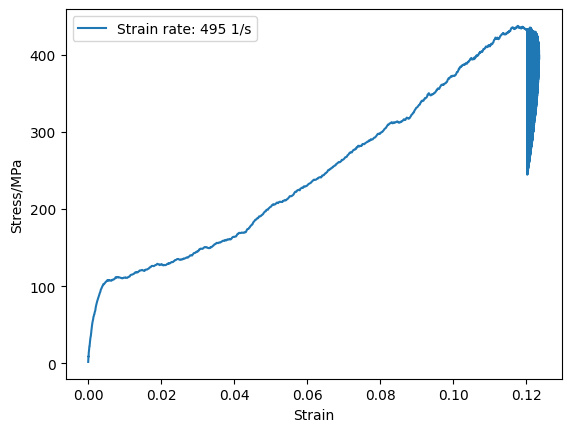

In [144]:
sns.lineplot(data=dfP,
                x = 'Strain',
                y = 'Stress/MPa',
                label = 'Strain rate: %.f 1/s' % strainRate,)

### d sigma / d epsilon. Specimen unloading

<AxesSubplot: xlabel='Strain', ylabel='E(eps)/MPa'>

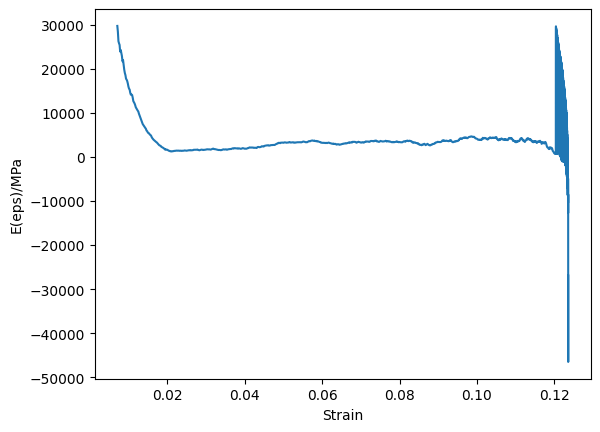

In [145]:
dfP['E(eps)/MPa'] = (dfP['Stress/MPa'].shift(-1) - dfP['Stress/MPa'])/(dfP['Strain'].shift(-1) - dfP['Strain'])
dfP['E(eps)/MPa'] = dfP['E(eps)/MPa'].rolling(100).mean()
unload = dfP['E(eps)/MPa'].idxmin()

sns.lineplot(data=dfP,
                x = 'Strain',
                y = 'E(eps)/MPa',
                )

In [146]:
dfP.drop(dfP.iloc[unload:].index, inplace=True)

<AxesSubplot: xlabel='Strain', ylabel='E(eps)/MPa'>

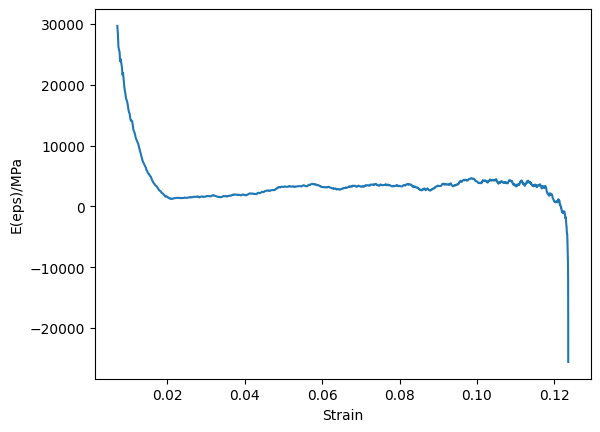

In [147]:
sns.lineplot(data=dfP,
                x = 'Strain',
                y = 'E(eps)/MPa',
                )

<AxesSubplot: xlabel='Strain', ylabel='Stress/MPa'>

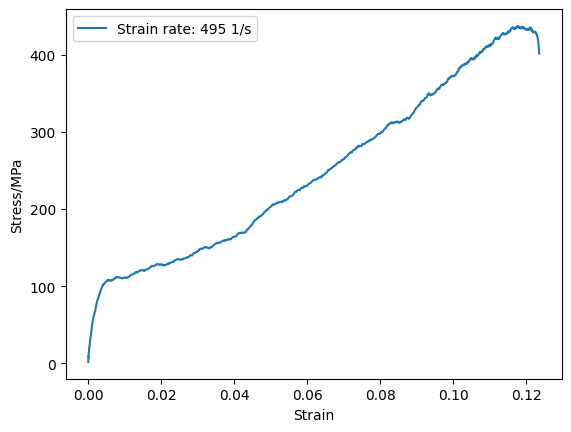

In [148]:
sns.lineplot(data=dfP,
                x = 'Strain',
                y = 'Stress/MPa',
                label = 'Strain rate: %.f 1/s' % strainRate,)
